In [95]:
# load data
import pandas as pd
lolita = pd.read_csv("cleaned_goodreads_reviews.csv", index_col=0)
tfidf_df = pd.read_csv("all_tfidf.csv", index_col=0)

In [96]:
# select features from tf-idf dataframe to use as predictors
selected_words = ['year', 'old', 'subject', 'unreliable', 'grown', 'girl', 'sure', 'crime'] 
select_df = tfidf_df.loc[:, selected_words]

In [98]:
# re-index reviews dataframe to merge with tf-idf dataframe
lolita = lolita.set_index(select_df.index)
df = lolita.join(select_df)

# drop observations that lack a star rating
df = df.dropna()

In [99]:
df.head()

,reviews,rating,year,old,subject,unreliable,grown,girl,sure,crime
0,local bookseller ever read firmly going either...,5.0,0.068522,0.072439,0.036109,0.02865,0.000000,0.000000,0.00000,0.071625
1,nymph nymphet never think year old way stain b...,5.0,0.047265,0.049967,0.066419,0.00000,0.000000,0.000000,0.00000,0.019762
2,going embarrassing know reading enjoying book ...,5.0,0.078394,0.062156,0.000000,0.00000,0.062931,0.074245,0.00000,0.049166
3,even going write review finishing honestly man...,4.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
4,first read book every second pride reader dist...,4.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.07359,0.000000


In [100]:
df['rating'].value_counts()

rating
5.0    2967
4.0    1249
3.0     398
1.0     199
2.0     199
Name: count, dtype: int64

In [101]:
# in new col, convert ratings from numerical to boolean; 5 stars = 1, > 5 stars = 0
five_dict = {5: 1, 4: 0, 3: 0, 2: 0, 1: 0}
df['rating'] = df['rating'].replace(five_dict)
df.head()

,reviews,rating,year,old,subject,unreliable,grown,girl,sure,crime
0,local bookseller ever read firmly going either...,1.0,0.068522,0.072439,0.036109,0.02865,0.000000,0.000000,0.00000,0.071625
1,nymph nymphet never think year old way stain b...,1.0,0.047265,0.049967,0.066419,0.00000,0.000000,0.000000,0.00000,0.019762
2,going embarrassing know reading enjoying book ...,1.0,0.078394,0.062156,0.000000,0.00000,0.062931,0.074245,0.00000,0.049166
3,even going write review finishing honestly man...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
4,first read book every second pride reader dist...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.07359,0.000000


In [102]:
# check distribution between class labels
df['rating'].describe()

count    5012.000000
mean        0.591979
std         0.491516
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: rating, dtype: float64

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold

# perform train-test split, stratified to preserve ratio of class labels
train, test = train_test_split(df, stratify=df['rating'], random_state=3)
train['idx']=range(len(train))
train = train.set_index('idx')

In [104]:
# set the dependent & independent variables. We will use multiple independent variables for this model
independent = selected_words

x_train = train[independent]
y_train = train['rating']
x_test = test[independent]
y_test = test['rating']

y_train.value_counts()

rating
1.0    2225
0.0    1534
Name: count, dtype: int64

In [105]:
# 10-fold cross-validation
kfold = StratifiedKFold(n_splits = 10)
logistic = LogisticRegression()

scores = []
intercepts=[]
year_coef=[]
old_coef=[]
subject_coef=[]
unreliable_coef=[]
grown_coef=[]
girl_coef=[]
sure_coef=[]
crime_coef=[]

results_lists=[scores, intercepts, year_coef, old_coef, subject_coef, unreliable_coef,grown_coef,
               girl_coef,sure_coef,crime_coef]

counter = 1
# for each of the 10 splits
for train_idx, test_idx in kfold.split(x_train, y_train):
    # set dependent & independent variables for the validation
    x_trn_fold, x_tst_fold = x_train.loc[train_idx], x_train.loc[test_idx]
    y_trn_fold, y_tst_fold = y_train.loc[train_idx], y_train.loc[test_idx]
    # fit logistic regression model
    logistic.fit(x_trn_fold, y_trn_fold)
    
    # calculate model accuracy & record estimated parameters
    #score = logistic.score(x_tst_fold,y_tst_fold)
    scores.append(logistic.score(x_tst_fold,y_tst_fold))
    intercepts.append(logistic.intercept_)
    for i in range(8):
        results_lists[i+2].append(logistic.coef_[0][i])
    
    print("Iteration ", counter, "\naccuracy: ", score, "          intercept: ", intercept, 
          "\n coefficients: ", coefs,"\n")
    counter += 1

Iteration  1 
accuracy:  0.784           intercept:  [0.32543076] 
 coefficients:  [[14.06878504 -1.68371884 -3.53534617  5.93223952 -5.30898066  1.69848181
  -7.29736809 -4.24443198]] 

Iteration  2 
accuracy:  0.784           intercept:  [0.32543076] 
 coefficients:  [[14.06878504 -1.68371884 -3.53534617  5.93223952 -5.30898066  1.69848181
  -7.29736809 -4.24443198]] 

Iteration  3 
accuracy:  0.784           intercept:  [0.32543076] 
 coefficients:  [[14.06878504 -1.68371884 -3.53534617  5.93223952 -5.30898066  1.69848181
  -7.29736809 -4.24443198]] 

Iteration  4 
accuracy:  0.784           intercept:  [0.32543076] 
 coefficients:  [[14.06878504 -1.68371884 -3.53534617  5.93223952 -5.30898066  1.69848181
  -7.29736809 -4.24443198]] 

Iteration  5 
accuracy:  0.784           intercept:  [0.32543076] 
 coefficients:  [[14.06878504 -1.68371884 -3.53534617  5.93223952 -5.30898066  1.69848181
  -7.29736809 -4.24443198]] 

Iteration  6 
accuracy:  0.784           intercept:  [0.32543076]

In [106]:
print(f"avg accuracy: {sum(results_lists[0])/10}\navg intercept est: {sum(results_lists[1])/10}")
print("average coefficient estimates: ")
print(f"'year': {sum(results_lists[2])/10}\n'old': {sum(results_lists[3])/10}\n'subject': {sum(results_lists[4])}")
print(f"'unreliable': {sum(results_lists[5])/10}\n'grown': {sum(results_lists[6])/10}")
print(f"'girl': {sum(results_lists[7])/10}\n'sure': {sum(results_lists[8])/10}\n'crime': {sum(results_lists[9])/10}")

avg accuracy: 0.7895702127659575
avg intercept est: [0.32450044]
average coefficient estimates: 
'year': 14.064844822327064
'old': -1.6937995952632168
'subject': -33.6227908512463
'unreliable': 5.816364014786968
'grown': -5.400658674393614
'girl': 1.8542619484600293
'sure': -7.337653670075892
'crime': -4.28760369091506


In [107]:
# use last validated model on testing data
y_pred = logistic.predict(x_test)

logistic.set_params()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, r2_score

# calculate model accuracy & mean squared error
accuracy = accuracy_score(y_test, y_pred, normalize=True)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

accuracy, mse, r2

print(f"accuracy: {accuracy}, mean squared error: {mse}, r^2: {r2}")

accuracy: 0.7932960893854749, mean squared error: 0.20670391061452514, r^2: 0.144094081157922


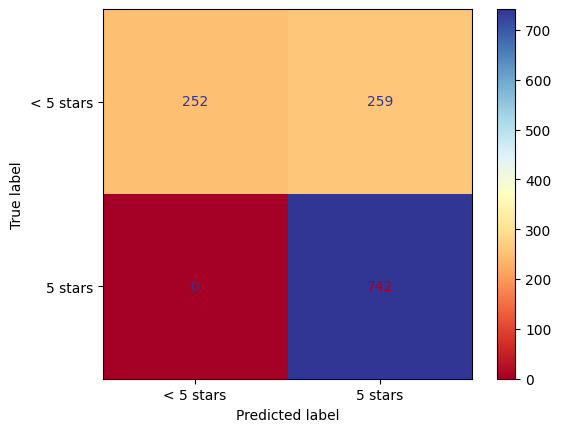

In [108]:
# model confusion matrix
metrics = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(metrics, display_labels=['< 5 stars', '5 stars'])
cm.plot(cmap="RdYlBu")